Tahmini parametreler (mu, sigma, p): [4.09666848 2.73771521 1.84028245]
En iyi log-likelihood: -166.40914163184934


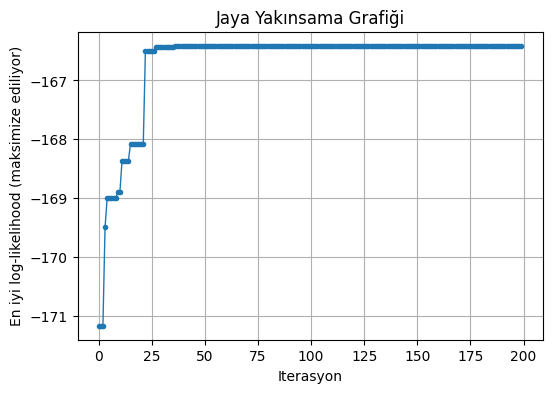

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Örnek veri üretimi (Weibull ile) ---
np.random.seed(0)
true_mu, true_sigma, true_p = 4.0, 3.0, 2.0
n = 100
# np.random.weibull returns samples of shape parameter a: X ~ weibull(a) with scale=1
# To get Weibull with scale sigma and shift mu: mu + sigma * np.random.weibull(p, n)
data = true_mu + true_sigma * np.random.weibull(true_p, n)

# --- Log-likelihood (negatif, çünkü minimize edilecek) ---
def neg_log_likelihood(theta, x):
    mu, sigma, p = theta
    # Geçersiz parametreleri eliyoruz
    if sigma <= 0 or p <= 0 or np.any(x <= mu):
        return np.inf
    z = (x - mu) / sigma
    # log-likelihood
    ll = np.sum(np.log(p/sigma) + (p-1)*np.log(z) - z**p)
    return -ll  # minimize etmek için negatif döndür

# --- Jaya algoritması (yakınsama takibiyle) ---
def jaya_with_tracking(x, pop_size=30, max_iter=200):
    # Başlangıç aralıkları (veriye göre ayarlanabilir)
    mu_min, mu_max = np.min(x) - 0.5, np.min(x) + 1.0
    sigma_min, sigma_max = 0.1, np.std(x) * 3
    p_min, p_max = 0.5, 6.0

    # Rastgele popülasyon (pop_size x 3)
    pop = np.column_stack([
        np.random.uniform(mu_min, mu_max, pop_size),
        np.random.uniform(sigma_min, sigma_max, pop_size),
        np.random.uniform(p_min, p_max, pop_size)
    ])

    # Başlangıç fitness değerleri (negatif log-likelihood; küçük = iyi)
    fitness = np.array([neg_log_likelihood(ind, x) for ind in pop])

    best_per_iter = []  # burada en iyi fitness (min) tutulacak

    for t in range(max_iter):
        best_idx = np.argmin(fitness)
        worst_idx = np.argmax(fitness)
        best = pop[best_idx].copy()
        worst = pop[worst_idx].copy()

        # Her bireyi güncelle
        for i in range(pop_size):
            r1, r2 = np.random.rand(), np.random.rand()
            candidate = pop[i] + r1 * (best - np.abs(pop[i])) - r2 * (worst - np.abs(pop[i]))

            # Eğer candidate parametreleri geçersizse atla veya sınırla
            # Basit sınırlandırma:
            candidate[1] = max(candidate[1], 1e-6)  # sigma > 0
            candidate[2] = max(candidate[2], 1e-6)  # p > 0

            # Fitness hesapla
            cand_fit = neg_log_likelihood(candidate, x)

            # Eğer daha iyi ise kabul et
            if cand_fit < fitness[i]:
                pop[i] = candidate
                fitness[i] = cand_fit

        # İterasyon sonunda en iyi fitness değerini kaydet
        best_per_iter.append(np.min(fitness))

    # Döngü bittiğinde en iyi çözümü getir
    final_best_idx = np.argmin(fitness)
    final_best = pop[final_best_idx]
    final_best_fit = fitness[final_best_idx]
    return final_best, final_best_fit, best_per_iter

# --- Çalıştır ---
best_theta, best_fit, best_trace = jaya_with_tracking(data, pop_size=40, max_iter=200)
print("Tahmini parametreler (mu, sigma, p):", best_theta)
print("En iyi log-likelihood:", -best_fit)  # negatif sakladığımız için işaret değiştir

# --- Grafik: yakınsama ---
plt.figure(figsize=(6,4))
# fitness küçük = iyi, biz pozitif log-likelihood görmek istiyoruz:
plt.plot(-np.array(best_trace), marker='o', markersize=3, linewidth=1)
plt.xlabel("Iterasyon")
plt.ylabel("En iyi log-likelihood (maksimize ediliyor)")
plt.title("Jaya Yakınsama Grafiği")
plt.grid(True)
plt.show()
